<a href="https://colab.research.google.com/github/soohyoen/artificial-intelligence/blob/main/AI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 분할 - Segmentation 

## 이미지에서 단순히 경계선을 추출하는 작업은 전통적인 알고리즘의 필터나
## 한 층의 컨볼루션 레이어로도 가능하지만, 의미 있는 부분을 추출하고 이미지를 
## 의미있는 부분과 그렇지 않은 부분으로 분할하기 위해서는 학습이 필요합니다. 
## 앞에서 배운 REDNet을 조금만 수정하면 이미지 분할(Segmentation)에 사용할 수 있습니다. 

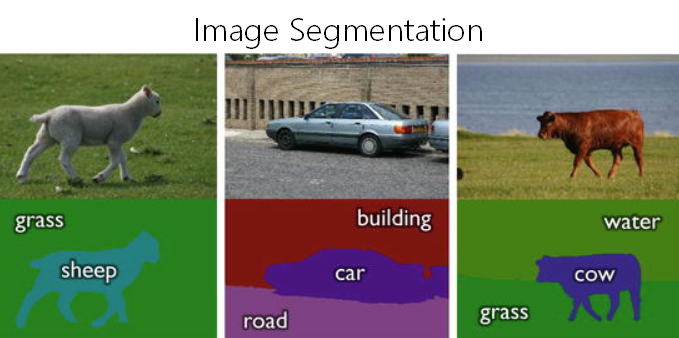

※ (이미지 분할 문제는 이미지의 각 픽셀들이 어떠한 범주인지 구분하는 문제)

## 아래 그림은 이미지 분할의 예시가 나와있습니다. 
## 이 연구에서는 이미지의 각 부분(픽셀)을 의미있는 부분집합으로 분류하고 있습니다. 
## 본 수업에서는 좀 더 쉽게 
## 이미지의 경계선과 내용, 그리고 외각 
## 3가지로 분류하는 Oxford - IIIT Pet 데이터세트로 
## 이미지 분할 문제를 학습해보도록 하겠습니다. 

## 먼저 데이터 세트를 불러오는 과정으로는 
## 다음과 같은 코드를 사용해 보도록 하겠습니다. 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## 먼저 데이터 세트를 불러와야 하는데, 이번에는 텐서플로 데이터 세트에서 
## 제공하는 데이터 세트를 바로 불러오겠습니다.

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete98P6JU/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete98P6JU/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## 텐서플로 데이터세트에서 가져오는 데이터는 
## 실제 Dataset과 Dataset에 대한 정보를 포함하고 있는 info로 구성되어 있습니다. 
## 그래서 info를 불러와 정보를 확인해보도록 하겠습니다.

In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

## 주요 정보를 저장하고 있는 변수는 features 입니다. 

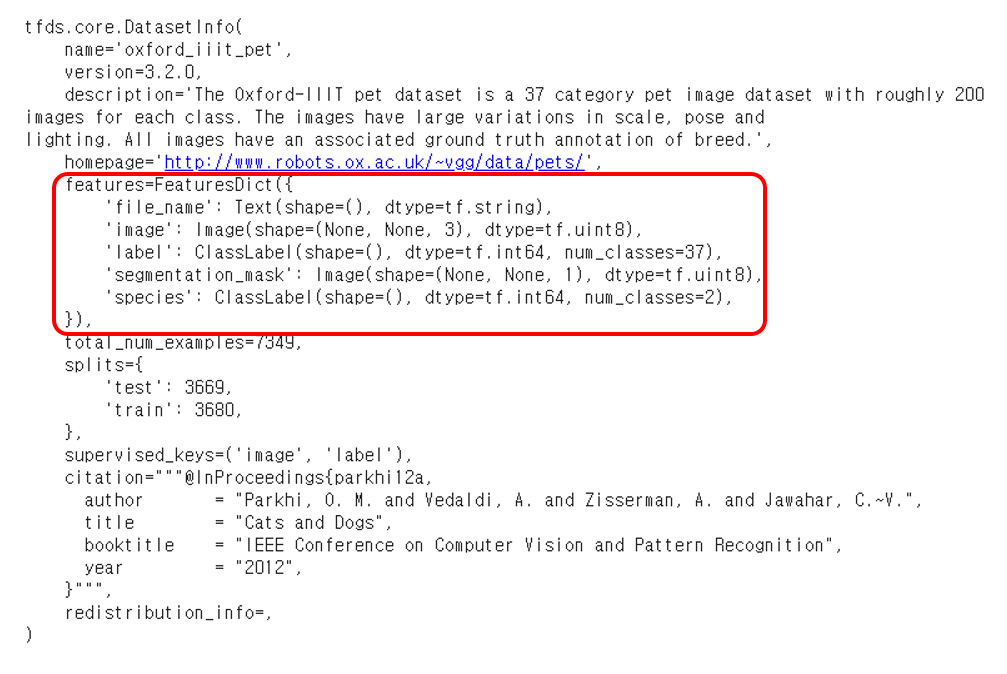

---
---
## 여기에는 image와 label, segmentation_mask, species 까지 확인이 가능합니다. 
## **label**은 각 반려동물에 대한 **클래스 정보**를 담고 있겠지만 
## 여기서는 라벨 분류를 학습하는 것이 아니기 때문에 다루지 않겠습니다. 
---
---
## image는 마지막 차원이 3인 것으로 보아 컬러 이미지 일 것이라고 추측할 수 있고,
---
--- 
## segmentation_mask는 마지막 차원이 1로 구성된 것을 볼 때 
## 흑백 이미지 처럼 다룰 수 있다고 추측해 볼 수 있습니다. 
---
---
## 더불어 species의 num_classes는 2라고 되어 있는 것으로 보아 
## 고양이와 강아지를 분류하는 값임을 추측해 볼 수 있습니다.

--- 
--- 

## 다음으로 splits 에는 Dataset가 훈련 데이터(train= 3680)와 
## 테스트 데이터(test=3669)로 분리돼 있다는 정보가 나옵니다 
## 이 두 숫자는 각 데이터 부분집합의 수를 나타내는데,
## 이 숫자는 Dataset을 학습 시킬 때 얼마나 반복시킬 것인지를 
## 계산할 때 사용하기 위해(fit_generator() 함수의 step_per_epoch 파라미터 설정) 
## 따로 저장해두도록 하겠습니다.

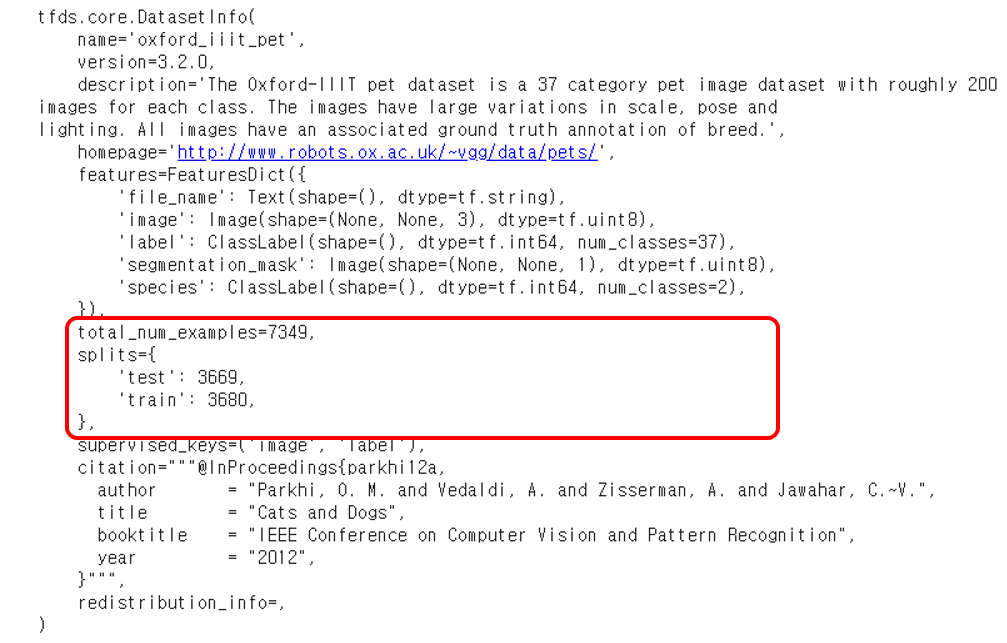

In [ ]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

In [ ]:
print("train_data_len : ", train_data_len)
print("test_data_len : ", test_data_len)

train_data_len :  3680
test_data_len :  3669


## 그 다음으로는 이미지를 불러오는 함수를 정의하겠습니다. 
## 현재 각 Dataset을 호출했을 때 받아올 수 있는 정보는 
## features에 있는 file_name, image, label, segmentation_mask 입니다. 
## 이 가운데 image와 segmentation_mask를 사용할 것이기 때문에 Dataset 원소를 받아서 
## 이 두 데이터를 반환하는 함수를 만들어 주겠습니다. 

In [ ]:
def load_image(datapoint):
    # 이미지를 받아와 가로 세로 동일크기인 (128×128) 픽셀로 크기를 반환합니다.
    # 이 크기가 다르면 tf.keras에서 학습이 되지 않기 때문입니다.  
    img = tf.image.resize(datapoint['image'], (128,128))
    # 다음은 segmentation_mask 이미지 또한 같은 크기로 변환하여 출력합니다. 
    mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))

    # 여기서 이미지는 floaf32로 데이터 타입을 바꿔주고, 
    # 정규화 과정을 진행하여 줍니다.  
    img = tf.cast(img,tf.float32)
    img = img / 255.0

    # 다음으로 마스크는 1을 빼주는 연산을 진행합니다.
    # 마스크 데이터에는 중심부, 외곽선, 배경을 뜻하는 1,3,2의 숫자가 
    # 각 픽셀에 대해 저장돼 있습니다.
    # 이미지 분할 문제는 기본적으로 각 픽셀을 분류하는 문제입니다.
    # 그래서 라벨이 1부터가 아닌, 0 부터 시작할 수 있도록 
    # 1,2,3을 0,1,2로 바꿔주기 위해 1을 빼주도록 하겠습니다.  
 
    # 중심부 1 → 0 // 배경 2 → 1 // 외곽선 3 → 2
    mask -= 1

    return img, mask

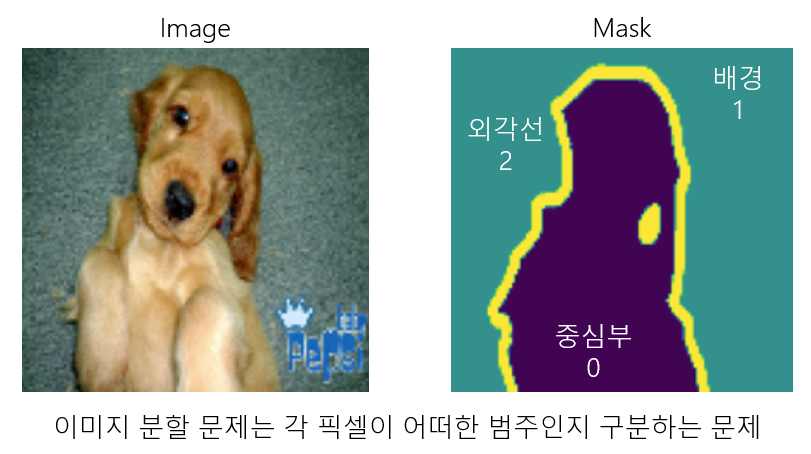

## 다음은 train, test Dataset 을 정의하는 단계입니다.

In [ ]:
# dataset 변수에 접근하여 load_image()를 적용하여 
# train_dataset을 정의하여 줍니다.
train_dataset = dataset['train'].map(load_image)
print(train_dataset)
# 출력 결과를 살펴보면 2개의 결괏값이 보여지는데, 
# (128,128,3)의 값은 이미지
# (128,128,1)의 값은 마스크를 의미합니다.

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>


In [ ]:
# 데이터를 반복학습 시켜줄 수 있도록 repeat() 를 적용시켜 줍니다.
train_dataset = train_dataset.repeat()

In [ ]:
# 배치 사이즈를 적용시켜 줍니다. 
train_dataset = train_dataset.batch(16)
print(train_dataset)

# 결과값을 살펴보면 더이상 3차원의 데이터가 아닌, 
# None 이라는 값의 1차원이 추가된 4차원 데이터임을 확인할 수 있습니다.
# ((128, 128, 3), (128, 128, 1)) → ((None, 128, 128, 3), (None, 128, 128, 1))

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [ ]:
# 학습 데이터와 같은 방식으로 테스트 데이터 또한 
# 데이터 추출, 반복학습을 위한 과정, 배치 과정까지 수행하여 줍니다.
test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

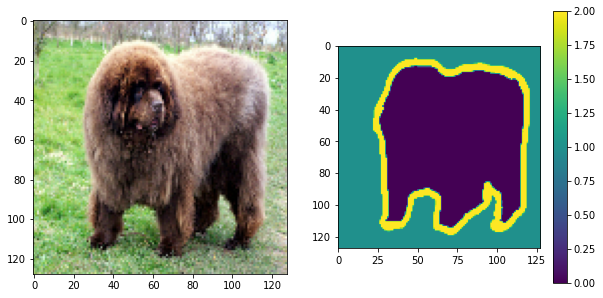

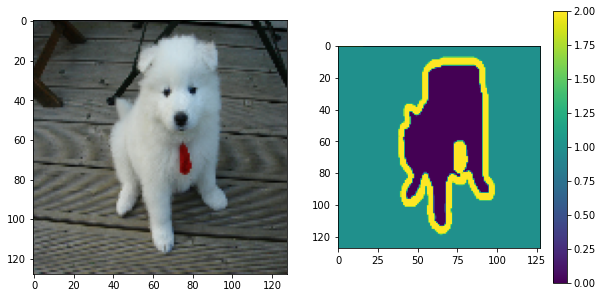

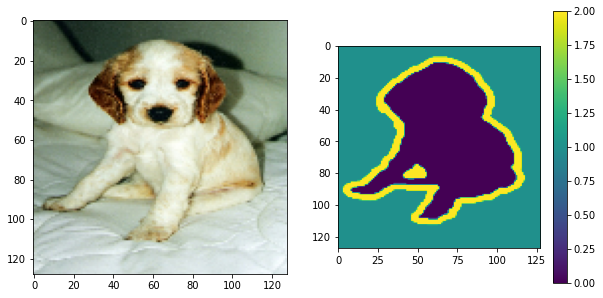

In [ ]:
# 학습 데이터 중 일부의 이미지와 마스크를 출력하여 보겠습니다. 
# take()는 데이터셋에서 가져올 수를 입력받습니다.
import numpy as np

for img, mask in train_dataset.take(3):
    
    i = np.random.choice(16)

    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    plt.imshow(img[i])

    plt.subplot(1,2,2)
    # 마스크 출력을 위해 np.squeeze() 를 적용하여 
    # 마지막 채널 차원을 지우고 출력하여 줍니다.  
    # (128, 128, 1) → (128, 128)
    
    # print(mask[i].shape)
    # print(np.squeeze(mask[i], axis = 2).shape)

    # >>> (128, 128, 1)
    # >>> (128, 128)
    plt.imshow(np.squeeze(mask[i], axis = 2))
    
    # 마스크의 각 픽셀에 대한 정보를 알기 위해
    # colorbar() 출력
    # 0 → 중심부 // 1 → 배경 // 2 → 외곽선  
    plt.colorbar()

---
---

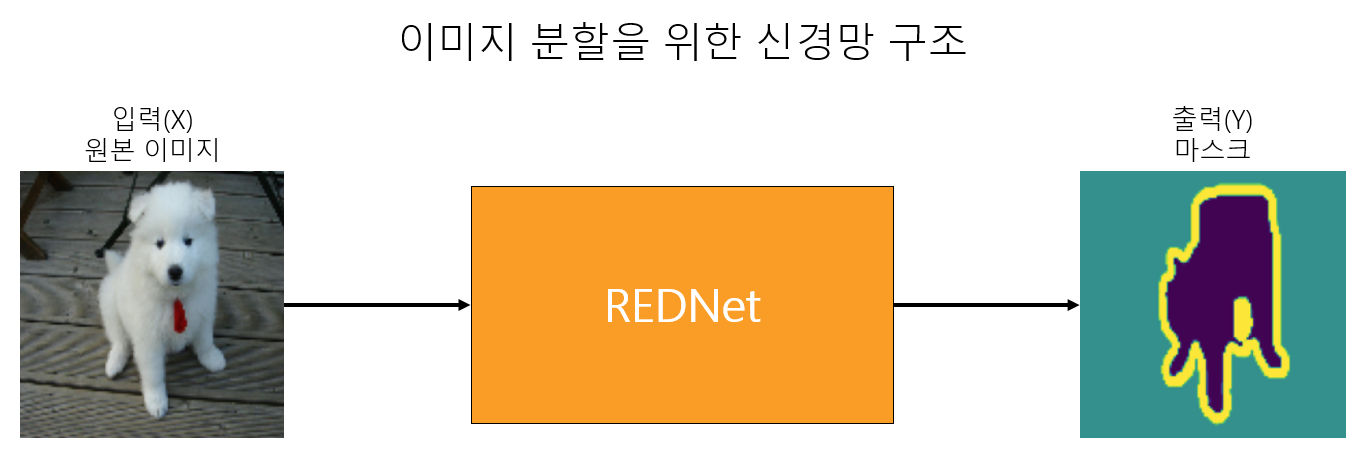

## 이미지 분할 신경망의 학습은 원본 이미지를 입력으로 했을 때 
## 마스크를 출력하게되는 구조입니다. 
## 이를 위해서는 앞서 공부하였던 오토인코더의 파생 신경망인 
## REDNet을 사용할 수 있습니다.
## 단, 마지막 레이어를 수정하여야 합니다.
---
---
## 기존에는 마지막 계층에 활성화 함수가 존재하지 않았습니다.
## 이제는 각 픽셀별로 라벨(0,1,2)이 붙기에 
## 선택분류 문제를 위한 활성화 함수 softmax()를 사용할 수 있습니다. 

## 구조는 다음과 같아집니다.

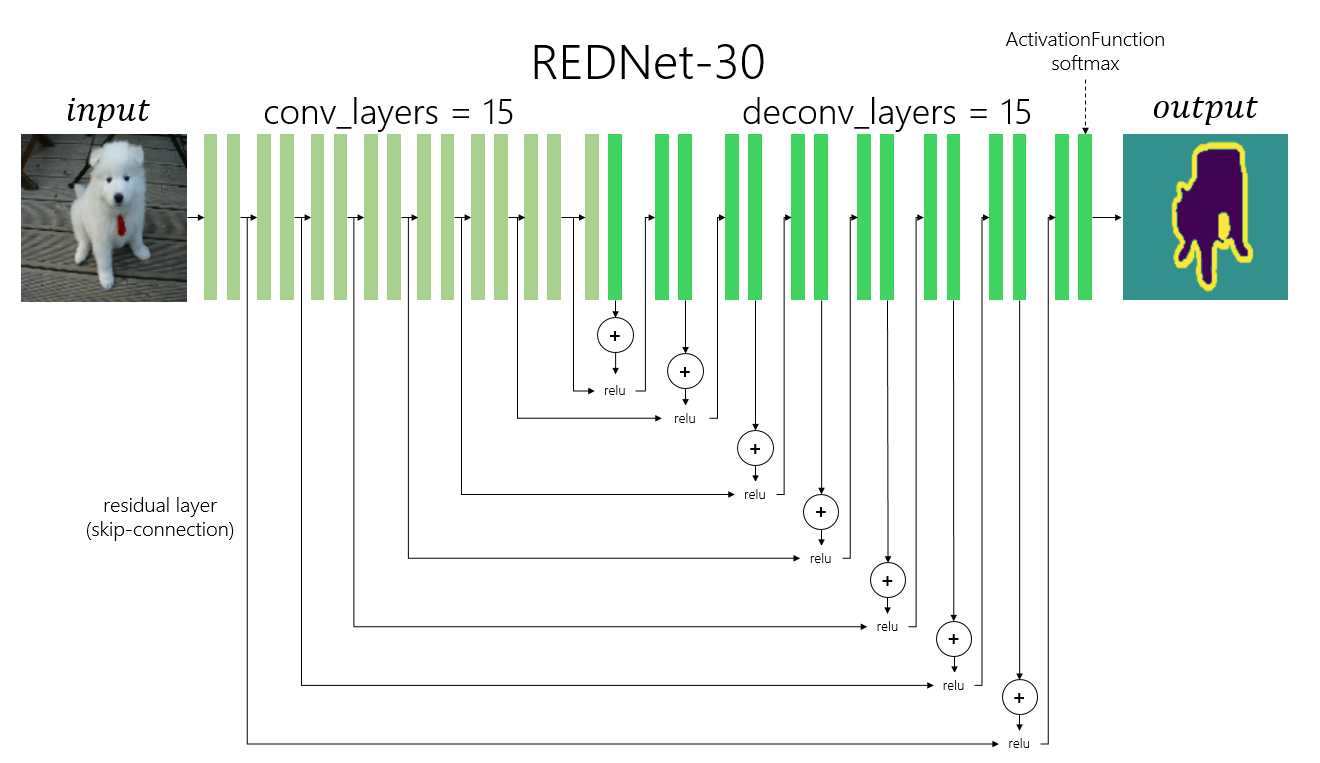

In [ ]:
def REDNet_segmentation(num_layers):

    # 먼저 세 개의 빈 리스트에 각각 컨볼루션 레이어, 디컽볼루션 레이어, skip-connetion입니다. 
    # 레이어가 많고 서로 연산을 해야하기 때문에 각 레이어를 저장할 리스트를 따로 생성하여 주겠습니다.  
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    # 입력 계층을 정의합니다. 채널값만 3으로 강제 지정하고 나머지는 None으로 설정합니다. 
    # 어떠한 크기의 이미지라도 입력받을 수 있게 합니다. 
    inputs = tf.keras.layers.Input(shape=(None, None,3))

    # 다음은 첫 번째 컨볼루션 레이어와 마지막 디컨볼루션 레이어는 따로 정의하고, 
    # 이 외의 중간에 있는 레이어는 반복문을 통해 정의해주도록 하겠습니다. 

    # 첫 번째 컨볼루션 레이어를 정의합니다.
    # 이 과정에서 필터의 수, 커널 사이즈, 패딩, 활성화 함수등을 정의합니다. 
    conv_layers.append(tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, padding='same', activation='relu'))

    # 중간 과정의 '레이어 구축'을 진행하는 과정입니다. 
    # 활성화 함수를 relu, 필터의 수는 64장, 활성화 함수 relu를 설정합니다. 
    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(filters = 64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=3, padding='same', activation='relu'))
    
    # 마지막 디컨볼루션 레이어도 필터의 수는 3, 커널 사이즈도 3으로 설정합니다.
    # 기존 활성화 함수는 존재하지 않았지만 픽셀 하나하나에 대한 라벨 분류 문제임을 고려하여 
    # 'softmax' 수정하여 줍니다. 
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size=3, padding='same', activation = 'softmax'))

    ##########################################################################################################

    # 인코더 시작 
    # 입력 레이어에 '첫 번째 컨볼루션 레이어'를 적용한 결과가 됩니다. 
    x = conv_layers[0](inputs)

    # 다음은 첫 번째 컨볼루션 레이어에 나머지 컨볼루션 레이어를 계속 적용시켜주는 과정입니다. 
    # num_layers = 15 
    for i in range(num_layers-1):

        # 다음번째 컨볼루션 레이어와 이전 컨볼루션 레이어를 연결시켜줍니다.  
        x = conv_layers[i+1](x)

        # 다음은 REDNet-30 처럼 짝수 텀 마다의 레이어마다의 결과를 
        # residual_layers 변수에 저장하여 줍니다. 
        if i % 2 == 0:
            residual_layers.append(x)

        # 이 과정까지의 결과를 표현하면 다음과 같습니다. 
        # inputs → 
        # 인코더 시작
        # conv_layers[0]  → conv_layers[1]  → residual_layers[0] → 
        # conv_layers[2]  → conv_layers[3]  → residual_layers[1] →
        # conv_layers[4]  → conv_layers[5]  → residual_layers[2] →
        # conv_layers[6]  → conv_layers[7]  → residual_layers[3] → 
        # conv_layers[8]  → conv_layers[9]  → residual_layers[4] →
        # conv_layers[10] → conv_layers[11] → residual_layers[5] →
        # conv_layers[12] → conv_layers[13] → residual_layers[6] → 
        # conv_layers[14] → 디코더 시작 


    # 디코더 시작 
    # num_layers = 15
    for i in range(num_layers - 1):
        
        # 마찬가지로 REDNet-30의 디코더를 정의하는 과정입니다.   

        # 컨볼루션을 통과한 결과를 residual_layers과 결합하여 줍니다.
        # 이때 residual_layers의 마지막 계층부터 결합시켜주기 위해 pop()를 사용합니다.  

        # 그리고 활성화 함수 relu와 연결시켜 줍니다.  

        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        # 디코더 시작 
        # deconv_layers[i] //       if i % 2 == 1       // deconv_layers[i]
        # --------------------------------------------------------------------
        # deconv_layers[0] + residual_layers[6] → relu → deconv_layers[1] →
        # deconv_layers[2] + residual_layers[5] → relu → deconv_layers[3] →
        # deconv_layers[4] + residual_layers[4] → relu → deconv_layers[5] →
        # deconv_layers[6] + residual_layers[3] → relu → deconv_layers[7] →
        # deconv_layers[8] + residual_layers[2] → relu → deconv_layers[9] →   
        # deconv_layers[10] + residual_layers[1] → relu → deconv_layers[11] →
        # deconv_layers[12] + residual_layers[0] → relu → deconv_layers[13] →             

        # deconv_layers[14] → output

        # REDNet-30의 디코더 부분은 디컨볼루션 레이어가 먼저 하나가 붙습니다.  

        # 위 조건문의 i 값이 0인 경우는 실행되지 않으므로 
        # i 값이 1인 경우부터 실행되기에 
        #  첫 번째 디컨볼루션 레이어를 구축 과정 그리고 relu 이후의 디컨볼루션 레이어가
        # 연결되는 코드를 생성하여 줍니다.   

        x = deconv_layers[i](x)

    # 마찬가지로 마지막 블록의 디컨볼루션 레이어 구축 과정입니다. 
    x = deconv_layers[-1](x)

    # 지금까지 구축한 레이어를 모아주는 과정입니다. 
    model = tf.keras.Model(inputs = inputs, outputs = x)

    return model

## 다음은 분류를 위해 loss에 sparse_categorical_crossentropy를 사용하여 줍니다. 
## 분류의 정확도를 위해 metrics에 accracy를 할당하여 줍니다. 

In [ ]:
model = REDNet_segmentation(15)
model.summary()

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

## 학습을 위한 과정입니다. 
## 이미지 분할은 초해상도(SR) 이미지를 얻는 문제보다는 쉽습니다.
## 그렇기에 적당한 Epoch 값을 설정하여 줍니다.
## 검증 데이터는 학습에서 분할하기에는 너무 부족하기에 
## 테스트 데이터로 진행하였습니다. 

In [ ]:
# 학습을 위한 과정입니다. 
history = model.fit(train_dataset,
                    epochs = 100,
                    steps_per_epoch = train_data_len // 16,
                    validation_data = test_dataset,
                    validation_steps = test_data_len)

Epoch 1/100
230/230 [==============================] - 88s 303ms/step - loss: 0.8552 - accuracy: 0.5911 - val_loss: 0.8023 - val_accuracy: 0.6425
Epoch 2/100
230/230 [==============================] - 69s 300ms/step - loss: 0.7355 - accuracy: 0.6612 - val_loss: 0.7612 - val_accuracy: 0.6601
Epoch 3/100
230/230 [==============================] - 69s 300ms/step - loss: 0.6843 - accuracy: 0.6925 - val_loss: 0.7109 - val_accuracy: 0.6860
Epoch 4/100
230/230 [==============================] - 69s 300ms/step - loss: 0.6508 - accuracy: 0.7117 - val_loss: 0.6448 - val_accuracy: 0.7179
Epoch 5/100
230/230 [==============================] - 69s 301ms/step - loss: 0.6198 - accuracy: 0.7290 - val_loss: 0.6020 - val_accuracy: 0.7418
Epoch 6/100
230/230 [==============================] - 69s 301ms/step - loss: 0.5946 - accuracy: 0.7430 - val_loss: 0.5658 - val_accuracy: 0.7596
Epoch 7/100
230/230 [==============================] - 69s 301ms/step - loss: 0.5702 - accuracy: 0.7565 - val_loss: 0.5484 -

In [ ]:
model.save('REDNet-30-seg.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model('/content/REDNet-30-seg.h5')

# 예측을 위한 과정입니다.

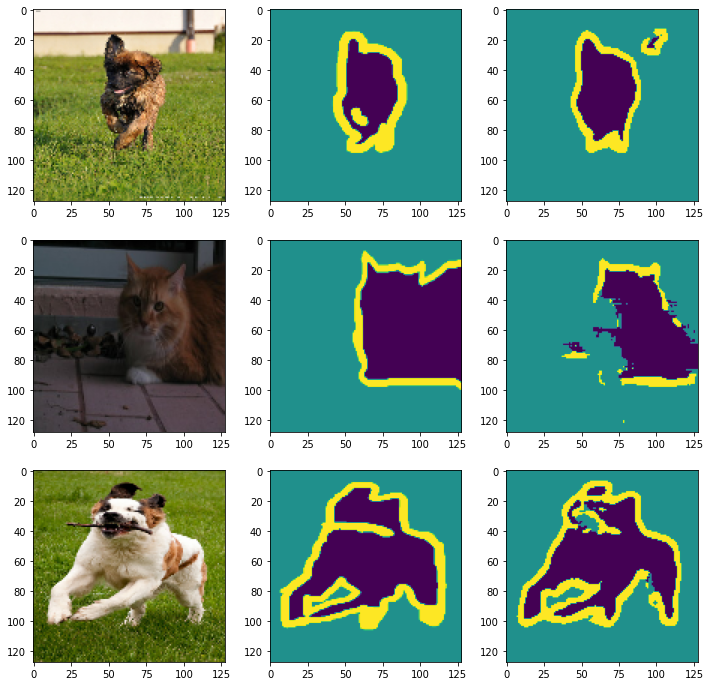

In [ ]:
# 이미지를 시각화 하는 부분입니다. 
plt.figure(figsize=(12, 12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))
    
    predict = tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(np.squeeze(predict, axis=0))

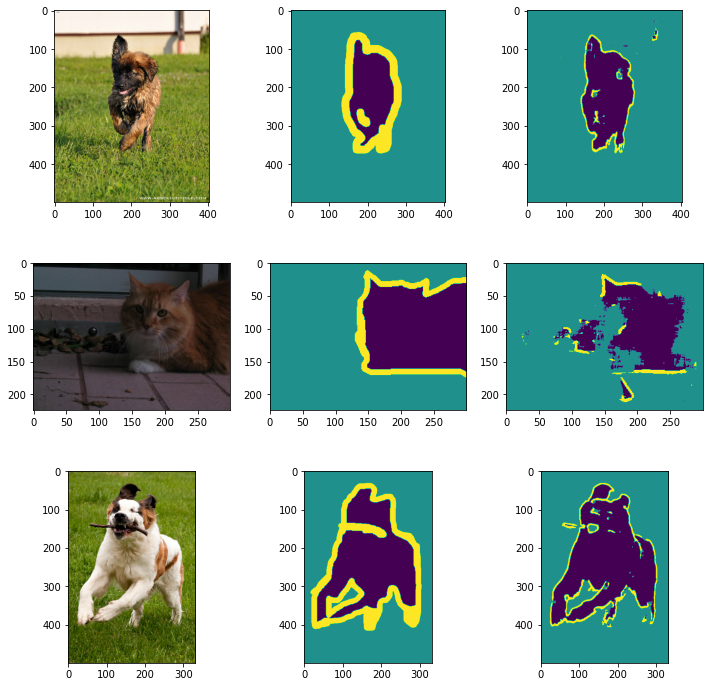

In [ ]:
# 본 사진 사이즈로 하여 다시 예측해보도록 합니다. 
plt.figure(figsize=(12, 12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']
    
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1
    
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img)
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask, axis=2))
    
    predict = tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(np.squeeze(predict, axis=0))

# 결과값을 살펴보면 노란색 외각선이 더 얇게 출력되고 있음을 알 수 있습니다.
# 이는 더 예측을 정밀하게 해놓은 것이라고 할 수 있습니다.

# 내가 원하는 사진을 바탕으로 이미지 분할을 수행하는 과정입니다. 

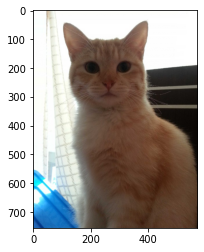

In [ ]:
seg_image = plt.imread('/content/cat_1.jpg')
seg_image = seg_image/ 255.0
plt.imshow(seg_image)
plt.show()

In [ ]:
seg_image_expand = np.expand_dims(seg_image,axis = 0)
seg_image_expand.shape

(1, 756, 571, 3)

In [ ]:
pred        = model.predict(seg_image_expand)
pred_argmax = tf.argmax(pred, axis = -1)
print("pred_argmax : \n", pred_argmax)

pred_argmax : 
 tf.Tensor(
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]], shape=(1, 756, 571), dtype=int64)


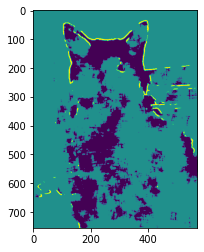

In [ ]:
plt.imshow(np.squeeze(pred_argmax, axis=0))
plt.show()

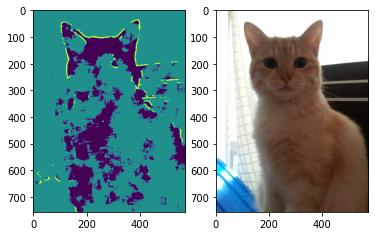

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(pred_argmax, axis=0))

plt.subplot(1, 2, 2)
plt.imshow(seg_image)

plt.show()